In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings
import sccoda
import anndata
import scanpy as sc
import rpy2
import os
import matplotlib

# scCODA Imports
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings

from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

warnings.filterwarnings("ignore")


In [2]:
# load the data
Non_SPN_scanpy = sc.read_h5ad("/endosome/work/Neuroinformatics_Core/gkonop/03_INTEGRATE_ALL/Non_SPN/ANNOTATION/GB_Non_SPN_AllSpecies_AllTissues_human_pr_coding_orthologs_ANNOTATED.h5ad")

# check
print(Non_SPN_scanpy.obs["orig.ident"].value_counts()) # check how many Non-SPNs are in each sample
print(Non_SPN_scanpy.obs["Species"].value_counts())
print(Non_SPN_scanpy.obs["intronRat"].value_counts())
print(Non_SPN_scanpy.obs["Age"].value_counts())
print(Non_SPN_scanpy.obs["Sex"].value_counts())
print(Non_SPN_scanpy.obs["Tissue"].value_counts())
print(Non_SPN_scanpy.obs["newannot"].value_counts())

# Check the unique labels in the 'newannot' column to confirm the exact label you want to remove
print(Non_SPN_scanpy.obs['newannot'].unique())

# Convert the 'newannot' column to categorical
Non_SPN_scanpy.obs['newannot'] = Non_SPN_scanpy.obs['newannot'].astype('category')

# Make sure gene and cell names are OK
Non_SPN_scanpy.obs
Non_SPN_scanpy.var


# save counts to layers
Non_SPN_scanpy.layers['counts'] = Non_SPN_scanpy.raw.X.copy() # raw counts
Non_SPN_scanpy.layers['log1p'] = Non_SPN_scanpy.X.copy()


# Remove MT and RP genes
mt_genes= Non_SPN_scanpy.var_names[Non_SPN_scanpy.var_names.str.startswith('MT-')]
not_mt_genes=[not g for g in Non_SPN_scanpy.var_names.isin(mt_genes)]
Non_SPN_scanpy=Non_SPN_scanpy[:,not_mt_genes].copy()

RP_genes= Non_SPN_scanpy.var_names[Non_SPN_scanpy.var_names.str.startswith('RP')]
not_RP_genes=[not g for g in Non_SPN_scanpy.var_names.isin(RP_genes)]
Non_SPN_scanpy=Non_SPN_scanpy[:,not_RP_genes].copy()

# check
Non_SPN_scanpy # 21776 cells 72018 genes 

Put_4            750
Put_1            704
Caud_3           650
Sample_25        619
Put_3            609
                ... 
Sample_242997    115
Sample_242942     89
Sample_243000     83
SRR13808463       79
Sample_20         76
Name: orig.ident, Length: 66, dtype: int64
Macaque     5286
Bat         4790
Marmoset    2845
Chimp       2668
Human       2420
Mouse       2077
Ferret       803
Name: Species, dtype: int64
0.800000    10
0.750000     3
0.766667     3
0.818182     2
0.793893     2
            ..
0.731438     1
0.750766     1
0.778256     1
0.741772     1
0.771604     1
Name: intronRat, Length: 18766, dtype: int64
16.0    1074
3.0      914
9.0      803
5.0      751
37.0     694
7.0      621
24.9     587
65.0     559
40.0     464
36.0     408
12.0     401
62.0     385
40.1     361
34.9     343
14.0     284
44.1     275
59.0     274
49.0     265
3.5      225
60.0     218
4.0      213
69.0     140
51.0     115
Name: Age, dtype: int64
NA        11667
Male       5209
Female     401

AnnData object with n_obs × n_vars = 20889 × 14766
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'intronRat', 'Tissue', 'Species', 'Brain_Region', 'Age', 'PMI', 'Sex', 'Race', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'doublet_status', 'id', 'integrated_snn_res.2', 'SCT_snn_res.1', 'newannot', 'SCT_snn_res.0.1', 'integrated_snn_res.1', 'SCT_snn_res.0.3', 'log10UMI', 'type', 'integrated_snn_res.0.1', 'integrated_snn_res.0.5', 'nCount_integrated', 'nFeature_integrated', 'sex', 'age', 'Individual', 'animal', 'BICCN_id', 'alt_id', 'mtperc', 'tissue', 'broad_annot', 'cellbarc', 'id2'
    var: 'features'
    layers: 'counts', 'log1p'

In [3]:
# change working dir
os.chdir('/endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots/')
# check
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots


### scCODA - extract the count matrix which scCODA requires

In [4]:
# Select the data for Putamen or Caudoputamen tissues
Non_SPN_scanpy_putamen = Non_SPN_scanpy[Non_SPN_scanpy.obs['Tissue'].isin(['Putamen', 'Caudoputamen'])].copy()

Non_SPN_scanpy_caud = Non_SPN_scanpy[Non_SPN_scanpy.obs['Tissue'].isin(['Caudate', 'Caudoputamen'])].copy()

# Create a DataFrame from the AnnData object
metadata_df_put = Non_SPN_scanpy_putamen.obs[['id', 'newannot', 'Species']].copy()
metadata_df_caud = Non_SPN_scanpy_caud.obs[['id', 'newannot', 'Species']].copy()
metadata_df_all = Non_SPN_scanpy.obs[['id', 'newannot', 'Species']].copy()

# Check unique id and Species pairs
unique_pairs_put = metadata_df_put[['id', 'Species']].drop_duplicates()
print("Unique id-Species pairs:")
print(unique_pairs_put)

# Similarly for other tissues
unique_pairs_caud = metadata_df_caud[['id', 'Species']].drop_duplicates()
unique_pairs_all = metadata_df_all[['id', 'Species']].drop_duplicates()

# Create a unique mapping from id to Species
id_species_mapping_put = unique_pairs_put.groupby('id').first().reset_index()
id_species_mapping_caud = unique_pairs_caud.groupby('id').first().reset_index()
id_species_mapping_all = unique_pairs_all.groupby('id').first().reset_index()

# Convert to a dictionary for easy lookup
id_species_dict_put = id_species_mapping_put.set_index('id')['Species'].to_dict()
id_species_dict_caud = id_species_mapping_caud.set_index('id')['Species'].to_dict()
id_species_dict_all = id_species_mapping_all.set_index('id')['Species'].to_dict()

# Map the species to the metadata_df using the generated dictionary
metadata_df_put['Species'] = metadata_df_put['id'].map(id_species_dict_put)
metadata_df_caud['Species'] = metadata_df_caud['id'].map(id_species_dict_caud)
metadata_df_all['Species'] = metadata_df_all['id'].map(id_species_dict_all)

# Count occurrences of each newannot_2 for each sample_id and species
## Putamen
count_df_put = metadata_df_put.groupby(['id', 'Species', 'newannot']).size().reset_index(name='count')

# Display the resulting DataFrame
print("Counts_df:")
print(count_df_put)

# Pivot the DataFrame to create the count matrix
cell_counts_put = count_df_put.pivot_table(index=['id', 'Species'], 
                                     columns='newannot', 
                                     values='count', 
                                     fill_value=0)

count_df_all = metadata_df_all.groupby(['id', 'Species', 'newannot']).size().reset_index(name='count')

# Caudate
# Count occurrences of each newannot_2 for each sample_id and species
count_df_caud = metadata_df_caud.groupby(['id', 'Species', 'newannot']).size().reset_index(name='count')

# Display the resulting DataFrame
print("Counts_df:")
print(count_df_caud)

# Pivot the DataFrame to create the count matrix
cell_counts_caud = count_df_caud.pivot_table(index=['id', 'Species'], 
                                     columns='newannot', 
                                     values='count', 
                                     fill_value=0)

# All
# Display the resulting DataFrame
print("Counts_df_all:")
print(count_df_all)

# Pivot the DataFrame to create the count matrix
cell_counts_all = count_df_all.pivot_table(index=['id', 'Species'], 
                                     columns='newannot', 
                                     values='count', 
                                     fill_value=0)

# Flatten MultiIndex columns if necessary
cell_counts_put.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_put.columns]
cell_counts_caud.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_caud.columns]
cell_counts_all.columns = [col if isinstance(col, str) else col[1] for col in cell_counts_all.columns]

# Reset the index to convert id and Species from index to columns
cell_counts_put.reset_index(inplace=True)
cell_counts_caud.reset_index(inplace=True)
cell_counts_all.reset_index(inplace=True)

# To ensure that species information is included, we will merge it back
cell_counts_put = cell_counts_put.merge(id_species_mapping_put, on='id', how='left')
cell_counts_caud = cell_counts_caud.merge(id_species_mapping_caud, on='id', how='left')
cell_counts_all = cell_counts_all.merge(id_species_mapping_all, on='id', how='left')

# Display the resulting DataFrame
print("Cell Counts DataFrame:")
print(cell_counts_put)
print(cell_counts_caud)
print(cell_counts_all)

# Drop specific columns by index
# Note: Indexing starts at 0, so adjust accordingly based on your DataFrame structure
columns_to_drop = [1]  

# Create a cleaned DataFrame by dropping the specified columns
cell_counts_put = cell_counts_put.drop(cell_counts_put.columns[columns_to_drop], axis=1)
cell_counts_caud = cell_counts_caud.drop(cell_counts_caud.columns[columns_to_drop], axis=1)
cell_counts_all = cell_counts_all.drop(cell_counts_all.columns[columns_to_drop], axis=1)

# Display the cleaned DataFrame
print("Cleaned Cell Counts DataFrame:")
print(cell_counts_put)
print(cell_counts_caud)
print(cell_counts_all)

# Check the columns again
print("Columns after reset_index:")
print(cell_counts_put.columns)
print(cell_counts_caud.columns)
print(cell_counts_all.columns)


Unique id-Species pairs:
                                                       id   Species
CTATCCGCACTAAACC-Sample_242937      Sample_242937_Putamen     Human
GCACTAATCCATTTAC-Sample_242938      Sample_242938_Putamen     Human
TAATCTCTCACTGGGC-Sample_242939      Sample_242939_Putamen     Human
GCACATAGTCACGCTG-Sample_242940      Sample_242940_Putamen     Human
TTACCATGTCAGTCCG-Sample_242941      Sample_242941_Putamen     Human
GTTCTATTCGACATAC-Sample_242942      Sample_242942_Putamen     Human
TGCGACGCAGGTTCAT-Sample_242944      Sample_242944_Putamen     Human
CCACGTTTCCGACAGC-Sample_12              Sample_12_Putamen     Chimp
GTTACCCGTGCCCACA-Sample_16              Sample_16_Putamen     Chimp
GCATCTCCACTTGAAC-Sample_21              Sample_21_Putamen     Chimp
TGATTTCTCTGGGCAC-Sample_26C            Sample_26C_Putamen     Chimp
CAGGGCTGTTCGATTG-Sample_3                Sample_3_Putamen     Chimp
CTACATTAGCACTCAT-Sample_8                Sample_8_Putamen     Chimp
GACTTCCTCAGCTTCC-Sample

In [5]:
# Filter the DataFrame for rows where 'Species' is 'Ferret'
ferret_rows = cell_counts_caud[cell_counts_caud['Species_y'] == 'Ferret']

# Display the rows
print(ferret_rows)


                     id  CCK_VIP+  CCK_VIP-  CHAT  FOXP2_EYA2  \
84  SRR11921037_Caudate         0         0     0           0   
85  SRR11921037_Caudate         0         0     0           0   
86  SRR11921037_Caudate         9         5    32          69   
87  SRR11921037_Caudate         0         0     0           0   
88  SRR11921037_Caudate         0         0     0           0   
89  SRR11921037_Caudate         0         0     0           0   
90  SRR11921037_Caudate         0         0     0           0   
91  SRR11921038_Caudate         0         0     0           0   
92  SRR11921038_Caudate         0         0     0           0   
93  SRR11921038_Caudate         8         3    27          82   
94  SRR11921038_Caudate         0         0     0           0   
95  SRR11921038_Caudate         0         0     0           0   
96  SRR11921038_Caudate         0         0     0           0   
97  SRR11921038_Caudate         0         0     0           0   

    FOXP2_TSHZ2_BAT  LMO

In [6]:
# Now convert to scCODA format 
data_non_SPN_put = dat.from_pandas(cell_counts_put, covariate_columns=["id", "Species_y"]) 
data_non_SPN_caud = dat.from_pandas(cell_counts_caud, covariate_columns=["id", "Species_y"]) 
data_non_SPN_all = dat.from_pandas(cell_counts_all, covariate_columns=["id", "Species_y"]) 

# check
print(data_non_SPN_put.X)
print(data_non_SPN_put.obs)
print(data_non_SPN_caud.X)
print(data_non_SPN_caud.obs)
print(data_non_SPN_all.X)
print(data_non_SPN_all.obs)


[[ 6 28 81 ... 98 52 17]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  4 16 ... 26 27  4]
 [ 0  0  0 ...  0  0  0]]
                       id Species_y
0           Put_1_Putamen       Bat
1           Put_1_Putamen       Bat
2           Put_1_Putamen       Bat
3           Put_1_Putamen       Bat
4           Put_1_Putamen       Bat
..                    ...       ...
241  marm029_RXN2_Putamen  Marmoset
242  marm029_RXN2_Putamen  Marmoset
243  marm029_RXN2_Putamen  Marmoset
244  marm029_RXN2_Putamen  Marmoset
245  marm029_RXN2_Putamen  Marmoset

[246 rows x 2 columns]
[[  6  26  81 ... 152  91  23]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0  17  14 ...  70 179  21]
 [  0   0   0 ...   0   0   0]]
                 id Species_y
0    Caud_2_Caudate       Bat
1    Caud_2_Caudate       Bat
2    Caud_2_Caudate       Bat
3    Caud_2_Caudate       Bat
4    Caud_2_Caudate       Bat
..              

In [7]:
# Filter the rows for 'Ferret' in the 'Species_y' column
ferret_rows = data_non_SPN_caud[data_non_SPN_caud.obs['Species_y'] == 'Ferret']

# Print the rows (display the 'obs' DataFrame for "Ferret")
print(ferret_rows.obs)


                     id Species_y
84  SRR11921037_Caudate    Ferret
85  SRR11921037_Caudate    Ferret
86  SRR11921037_Caudate    Ferret
87  SRR11921037_Caudate    Ferret
88  SRR11921037_Caudate    Ferret
89  SRR11921037_Caudate    Ferret
90  SRR11921037_Caudate    Ferret
91  SRR11921038_Caudate    Ferret
92  SRR11921038_Caudate    Ferret
93  SRR11921038_Caudate    Ferret
94  SRR11921038_Caudate    Ferret
95  SRR11921038_Caudate    Ferret
96  SRR11921038_Caudate    Ferret
97  SRR11921038_Caudate    Ferret


### scCODA - Compositional data visualization

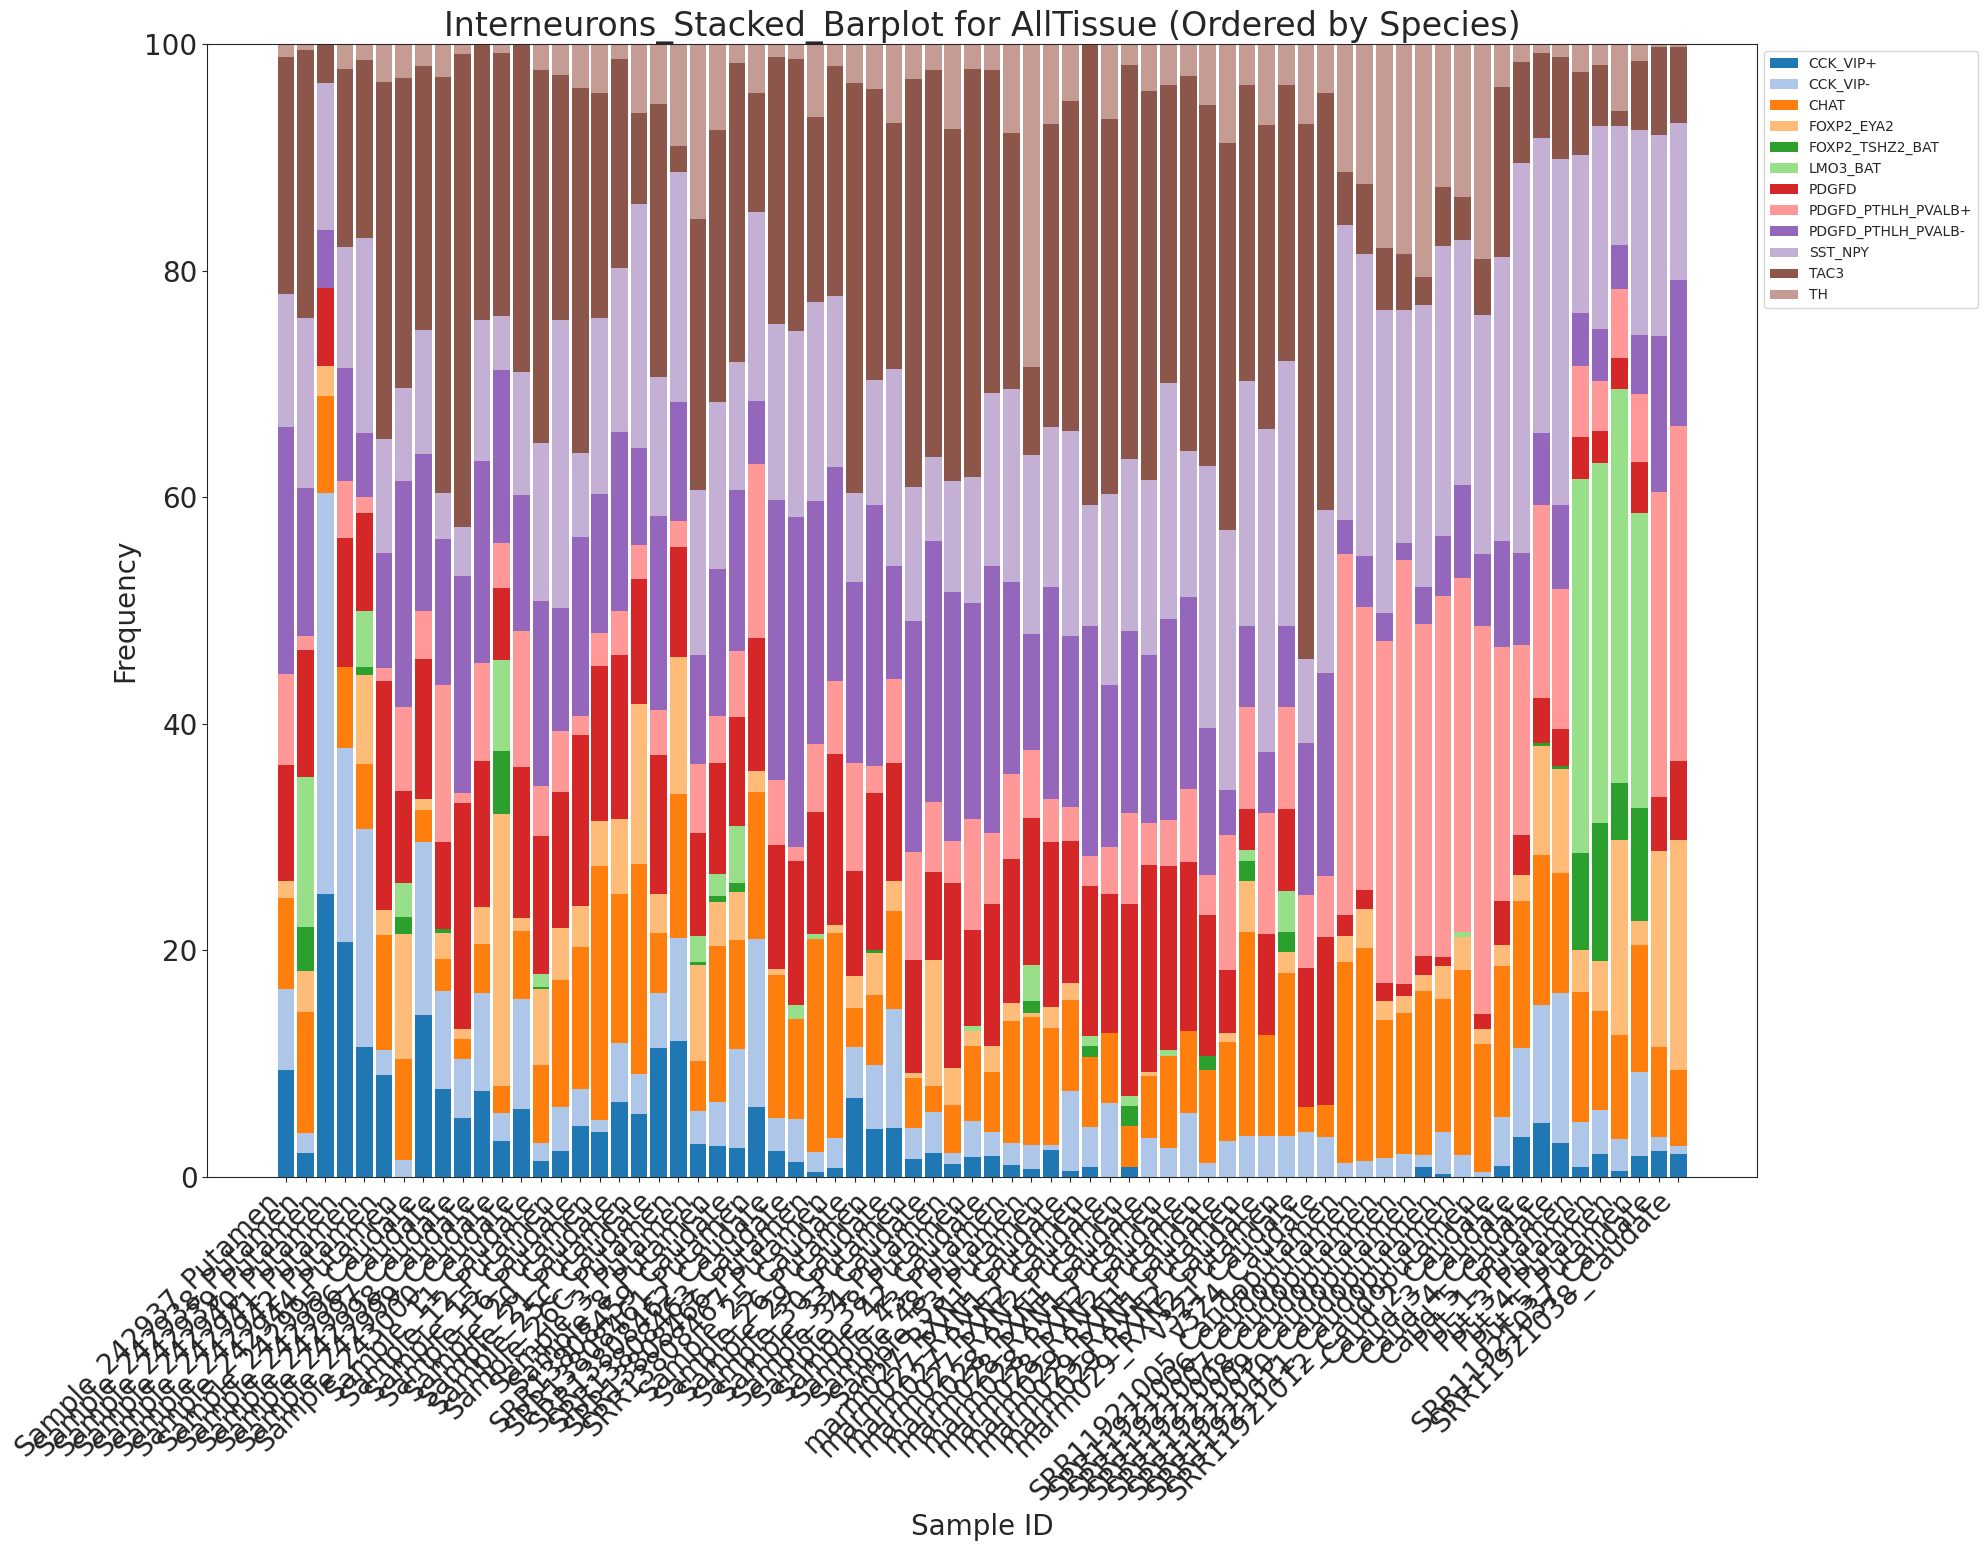

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# List of species in the desired order (human first, then chimp, macaque, etc.)
species_order_all = ["Human", "Chimp", "Macaque", "Marmoset", "Mouse", "Bat", "Ferret"]

# Reorder the data in the desired order by selecting from `obs` attribute
data_sorted_all_list = [
    data_non_SPN_all[data_non_SPN_all.obs['Species_y'] == species]
    for species in species_order_all
]

# Concatenate the AnnData objects into one AnnData object
data_sorted_all = data_sorted_all_list[0]  # Start with the first species

for adata in data_sorted_all_list[1:]:
    data_sorted_all = data_sorted_all.concatenate(adata)

# Now create the single stacked bar plot
viz.stacked_barplot(data_sorted_all, feature_name="id", figsize=(20, 15))

# Adjust font size after plot creation
plt.xticks(fontsize=20, rotation=45, ha="right")  # Rotate and adjust alignment for x-axis labels
plt.yticks(fontsize=20)  # Adjust y-axis label size
plt.xlabel('Sample ID', fontsize=20)  # Adjust x-axis label
plt.ylabel('Frequency', fontsize=20)  # Adjust y-axis label
plt.title('Interneurons_Stacked_Barplot for AllTissue (Ordered by Species)', fontsize=24)  # Adjust title size

# Save the plot as an SVG file
plt.savefig("Interneurons_stacked_barplot_AllTissue_species_ordered.svg", format='svg')
plt.show()  # Optional: To display the plot

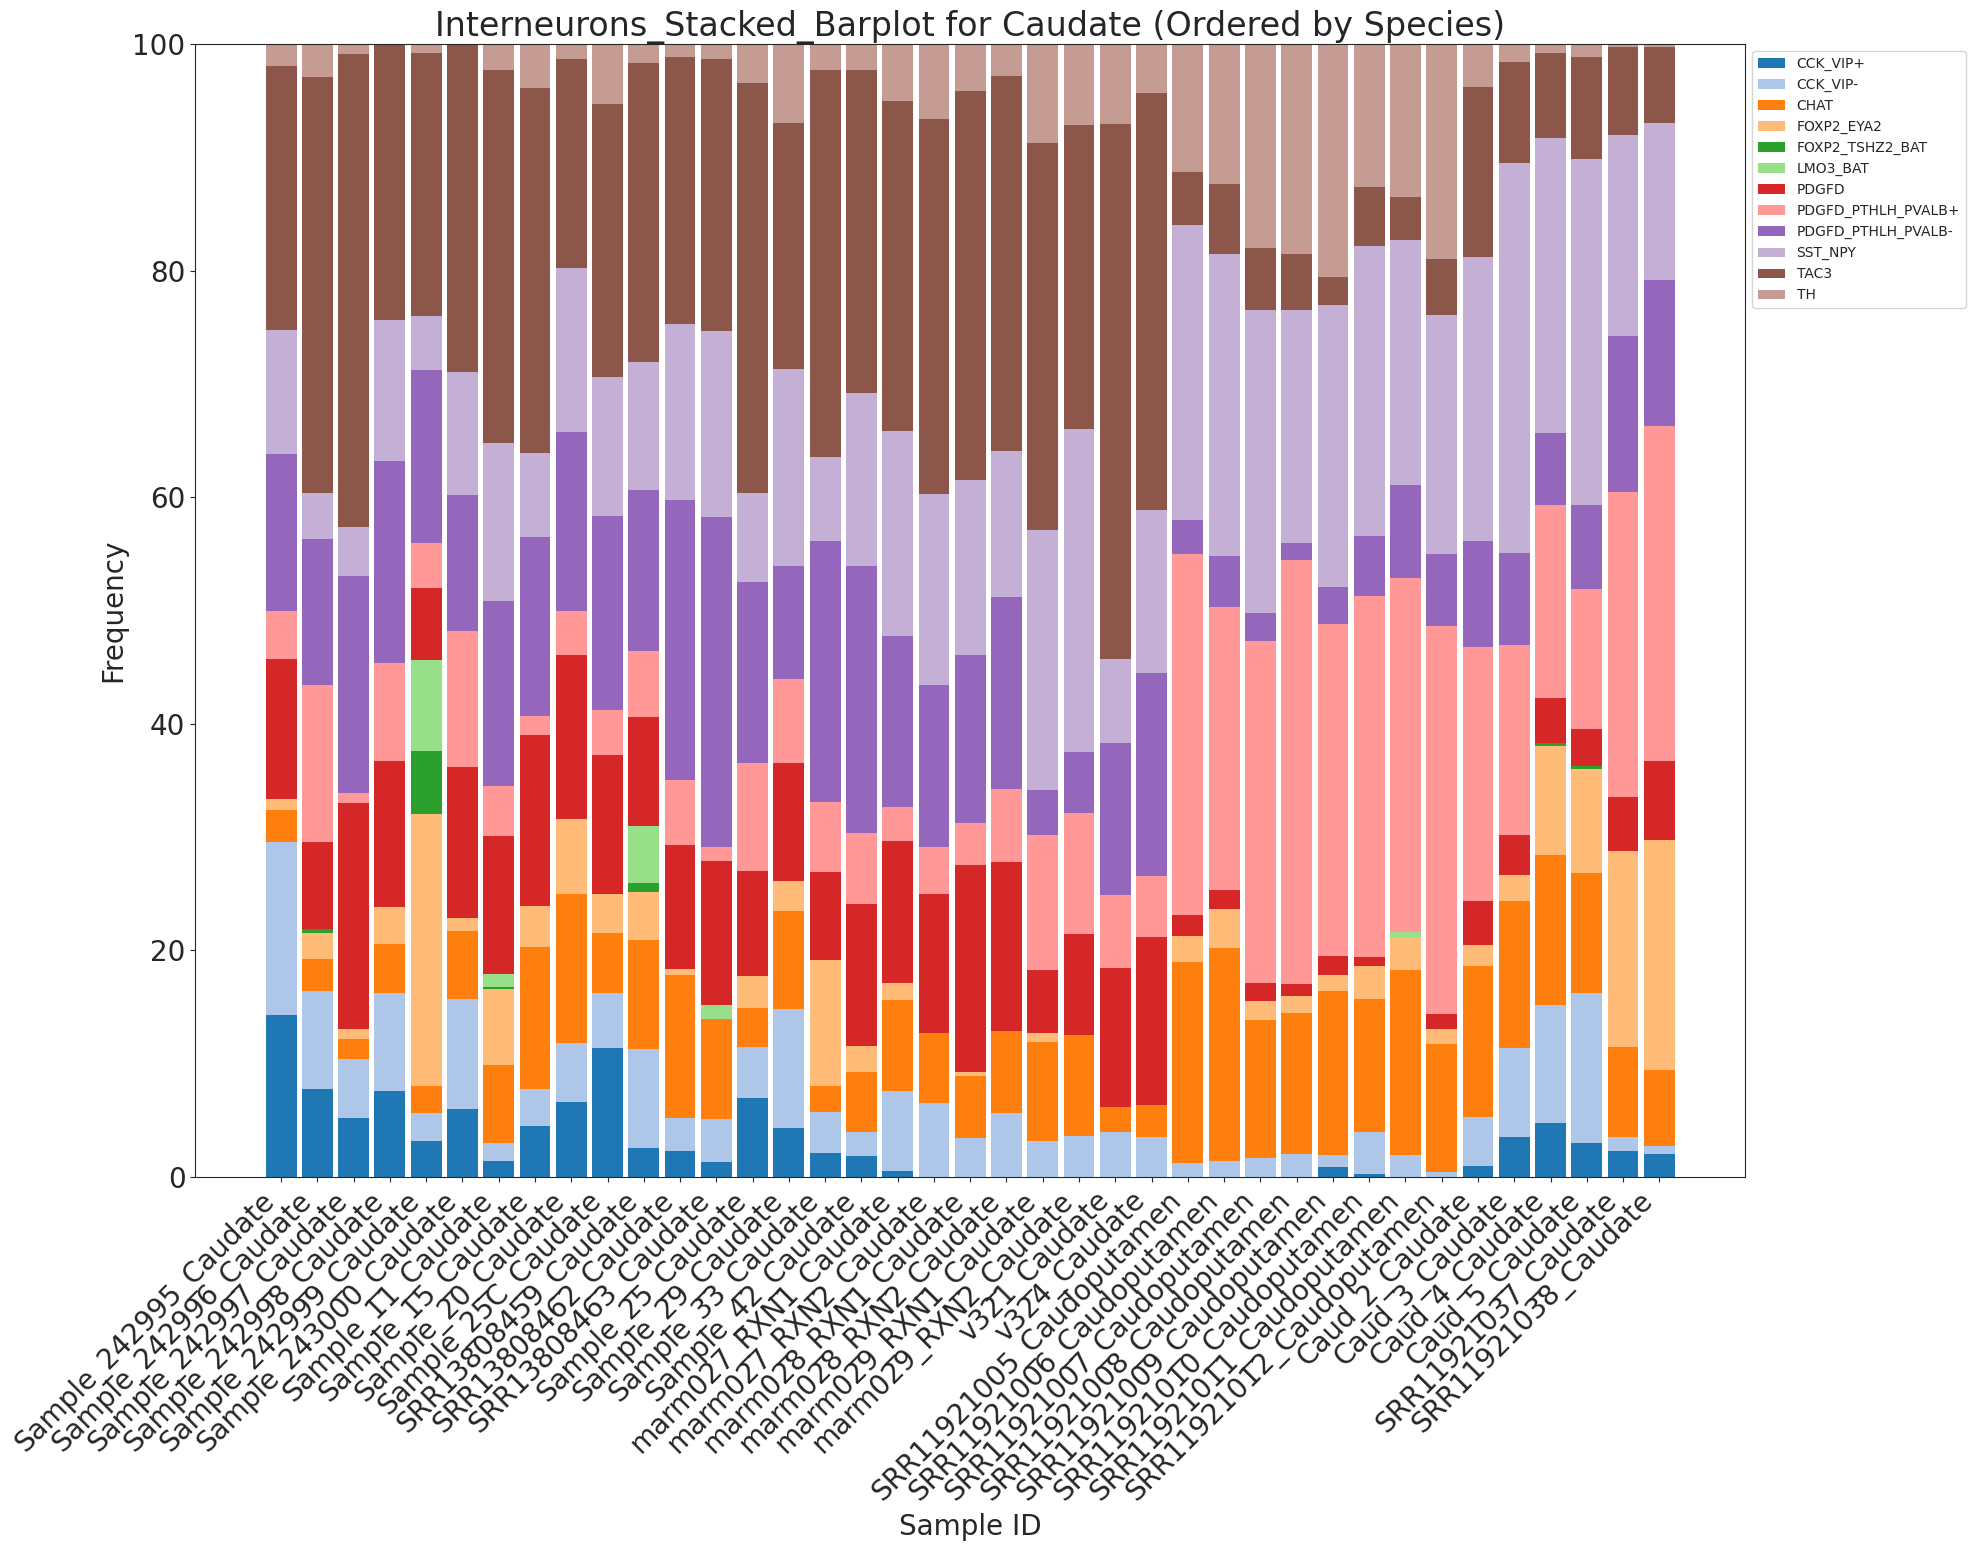

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# List of species in the desired order (human first, then chimp, macaque, etc.)
species_order_caud = ["Human", "Chimp", "Macaque", "Marmoset", "Mouse", "Bat", "Ferret"]

# Reorder the data in the desired order by selecting from `obs` attribute
data_sorted_caud_list = [
    data_non_SPN_caud[data_non_SPN_caud.obs['Species_y'] == species]
    for species in species_order_caud
]

# Concatenate the AnnData objects into one AnnData object
data_sorted_caud = data_sorted_caud_list[0]  # Start with the first species

for adata in data_sorted_caud_list[1:]:
    data_sorted_caud = data_sorted_caud.concatenate(adata)

# Now create the single stacked bar plot
viz.stacked_barplot(data_sorted_caud, feature_name="id", figsize=(20, 15))

# Adjust font size after plot creation
plt.xticks(fontsize=20, rotation=45, ha="right")  # Rotate and adjust alignment for x-axis labels
plt.yticks(fontsize=20)  # Adjust y-axis label size
plt.xlabel('Sample ID', fontsize=20)  # Adjust x-axis label
plt.ylabel('Frequency', fontsize=20)  # Adjust y-axis label
plt.title('Interneurons_Stacked_Barplot for Caudate (Ordered by Species)', fontsize=24)  # Adjust title size

# Save the plot as an SVG file
plt.savefig("Interneurons_stacked_barplot_Caudate_species_ordered.svg", format='svg')
plt.show()  # Optional: To display the plot

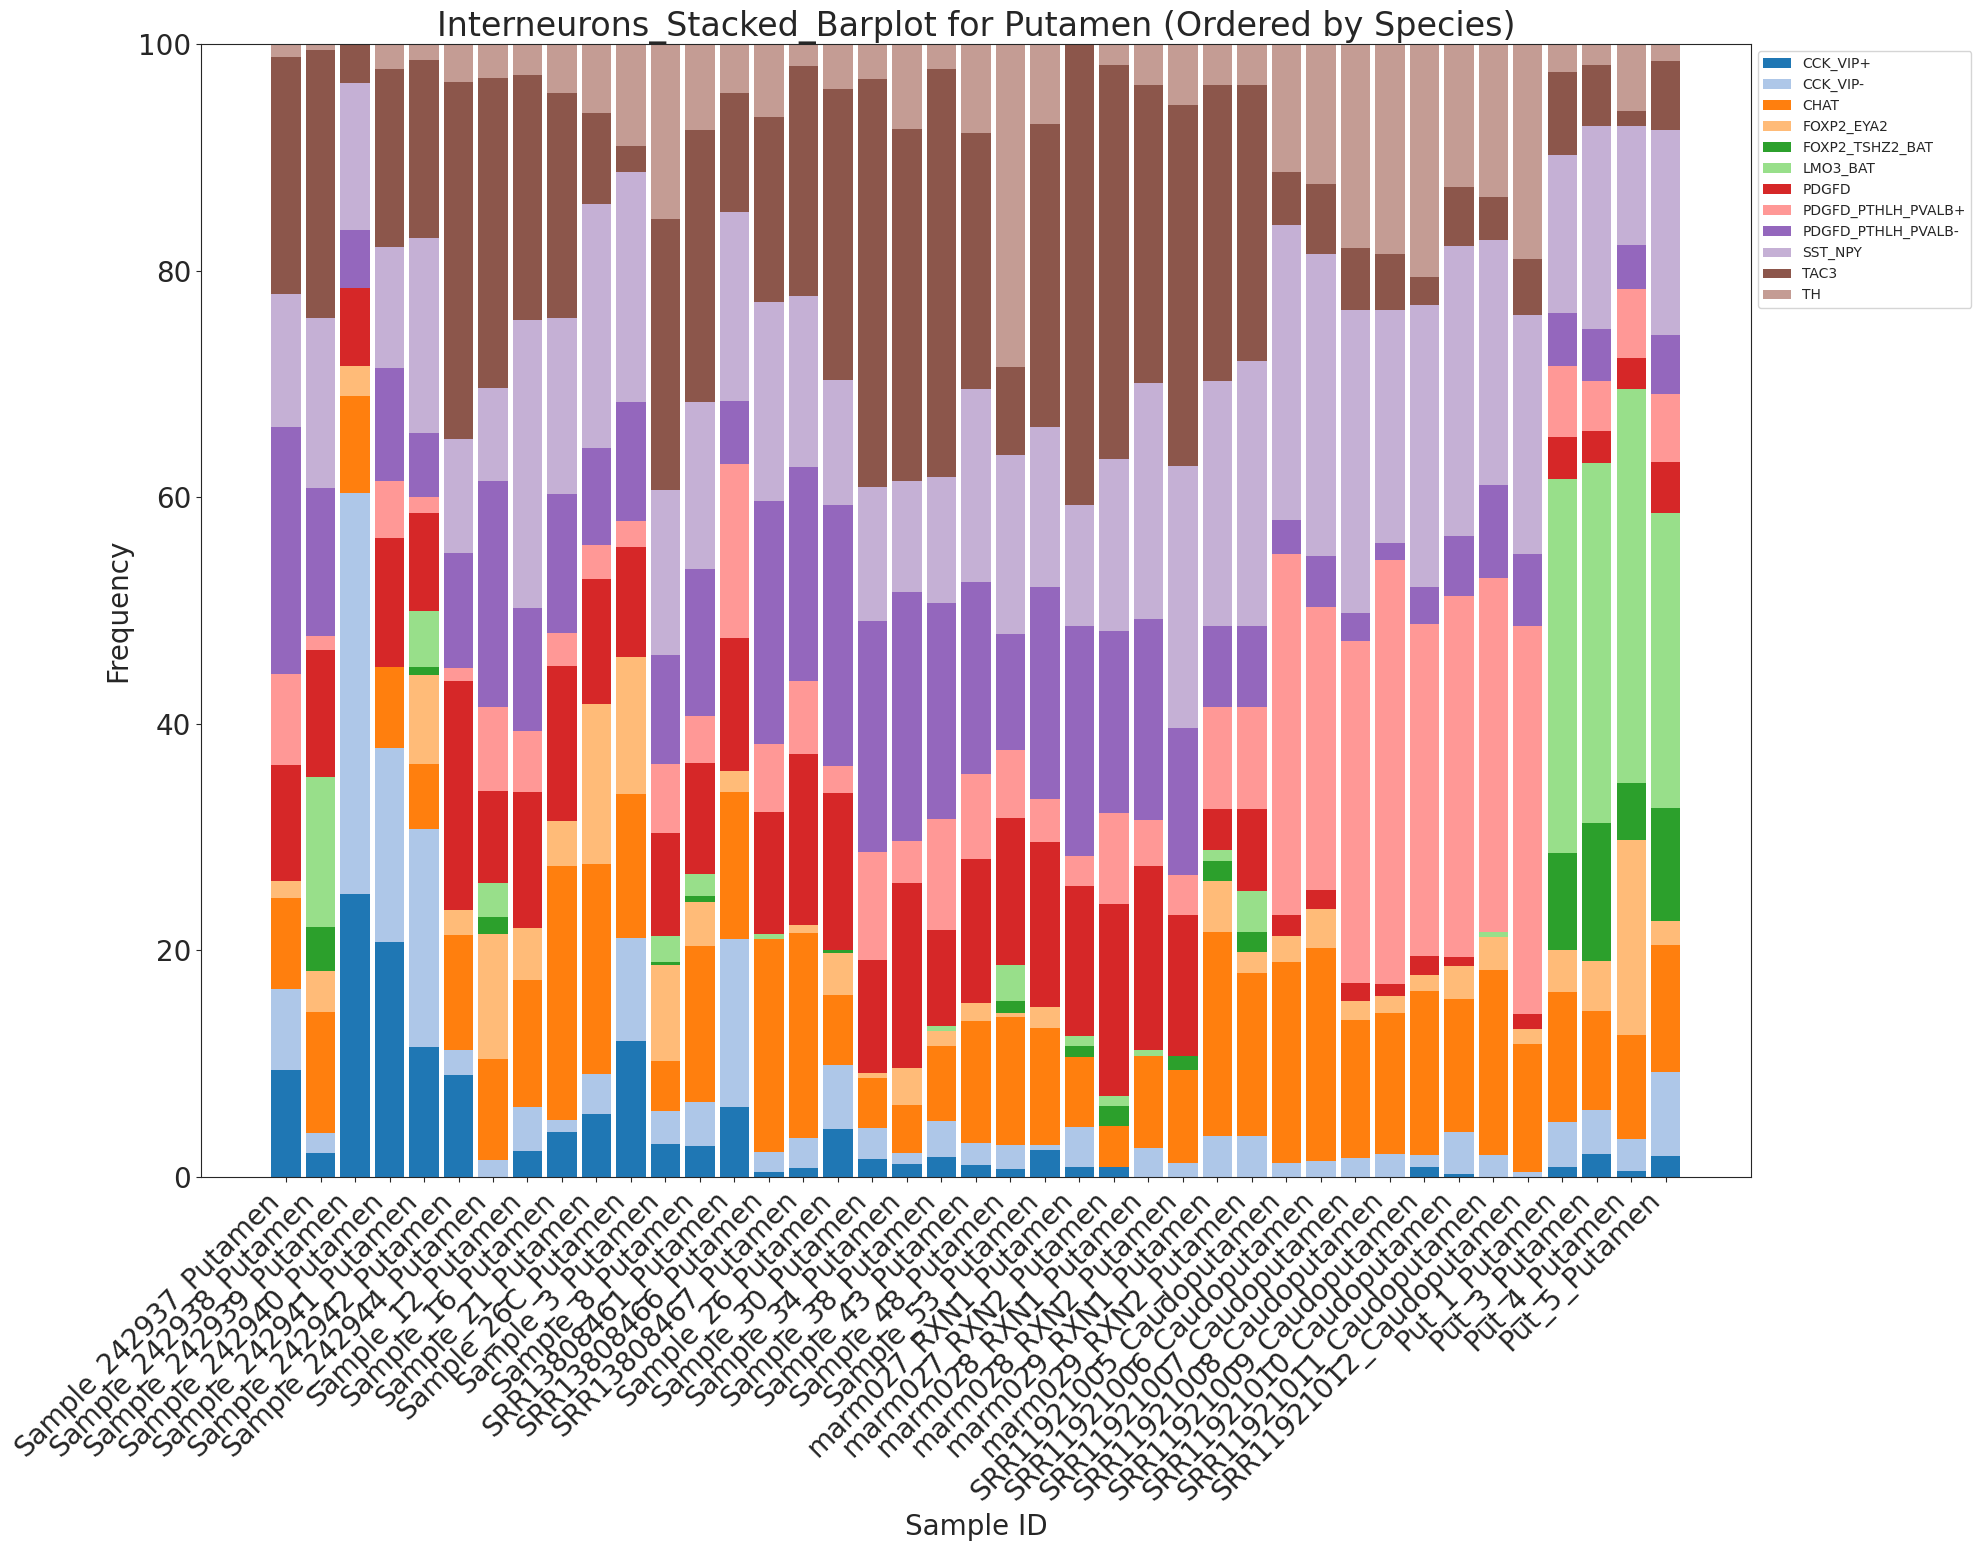

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# List of species in the desired order (human first, then chimp, macaque, etc.)
species_order_put = ["Human", "Chimp", "Macaque", "Marmoset", "Mouse", "Bat"]

# Reorder the data in the desired order by selecting from `obs` attribute
data_sorted_put_list = [
    data_non_SPN_put[data_non_SPN_put.obs['Species_y'] == species]
    for species in species_order_put
]

# Concatenate the AnnData objects into one AnnData object
data_sorted_put = data_sorted_put_list[0]  # Start with the first species

for adata in data_sorted_put_list[1:]:
    data_sorted_put = data_sorted_put.concatenate(adata)

# Now create the single stacked bar plot
viz.stacked_barplot(data_sorted_put, feature_name="id", figsize=(20, 15))

# Adjust font size after plot creation
plt.xticks(fontsize=20, rotation=45, ha="right") # Adjust x-axis label size
plt.yticks(fontsize=20)  # Adjust y-axis label size
plt.xlabel('Sample ID', fontsize=20)  # Adjust x-axis label
plt.ylabel('Frequency', fontsize=20)  # Adjust y-axis label
plt.title('Interneurons_Stacked_Barplot for Putamen (Ordered by Species)', fontsize=24)  # Adjust title size

# Save the plot as an SVG file
plt.savefig("Interneurons_stacked_barplot_Putamen_species_ordered.svg", format='svg')
plt.show()  # Optional: To display the plot


<Axes: title={'center': 'Species_y'}, ylabel='Proportion'>

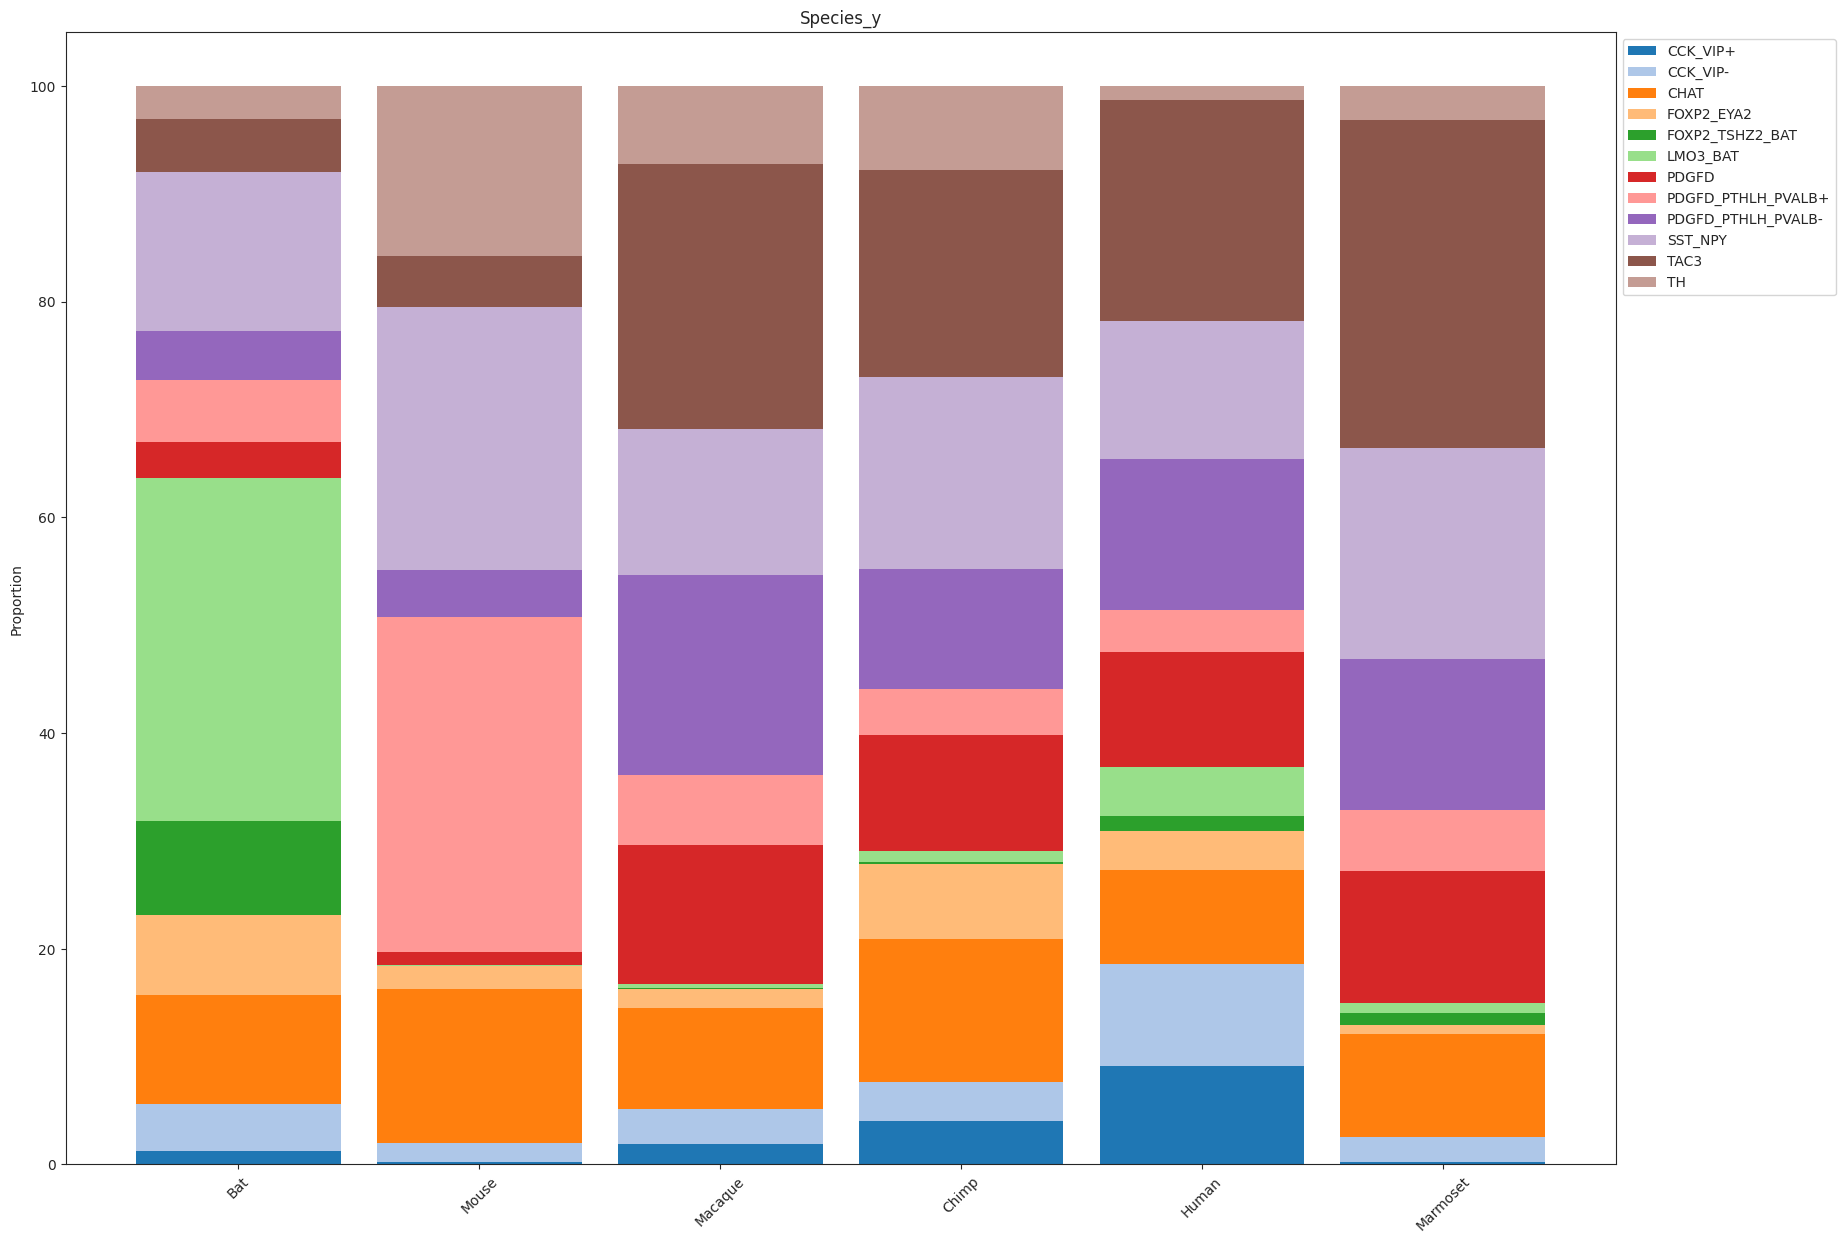

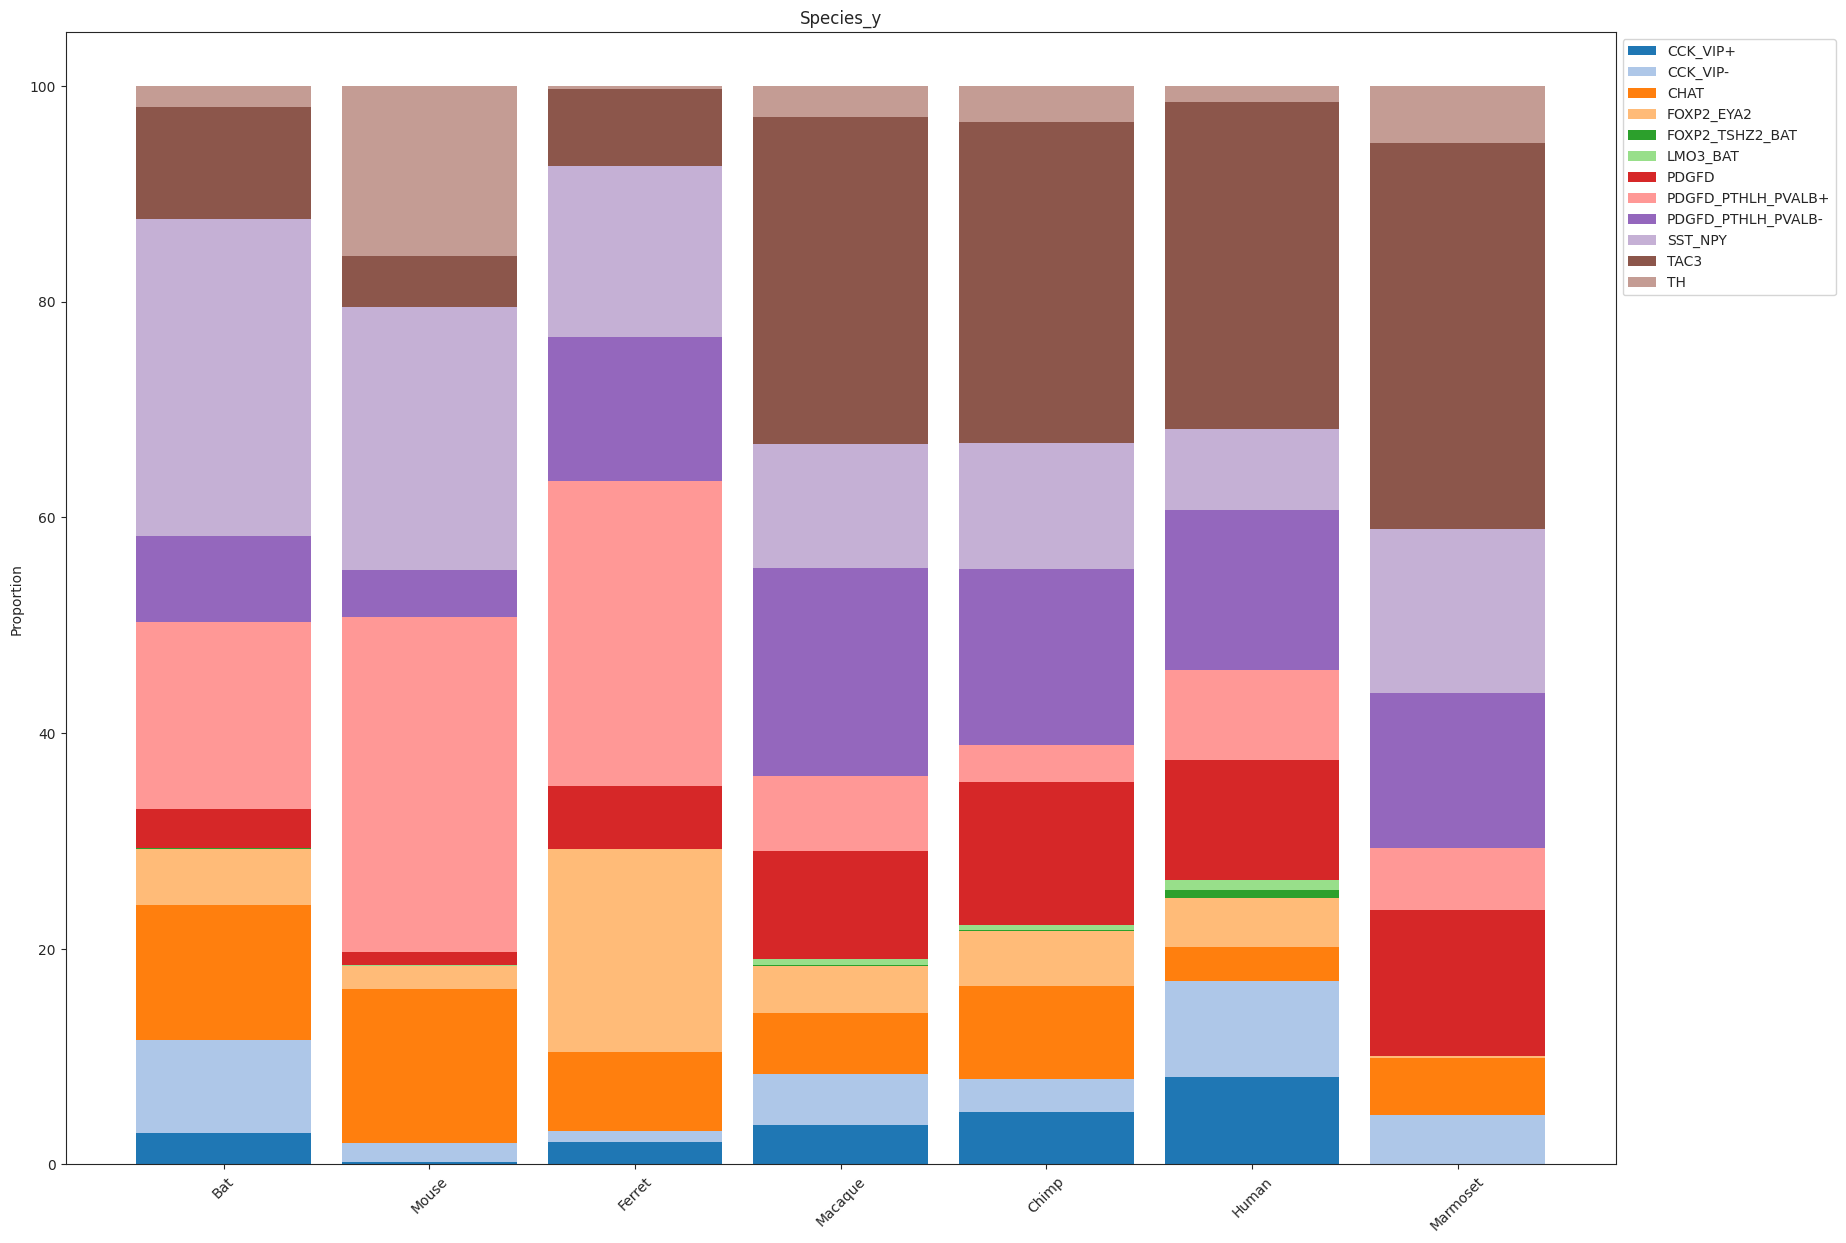

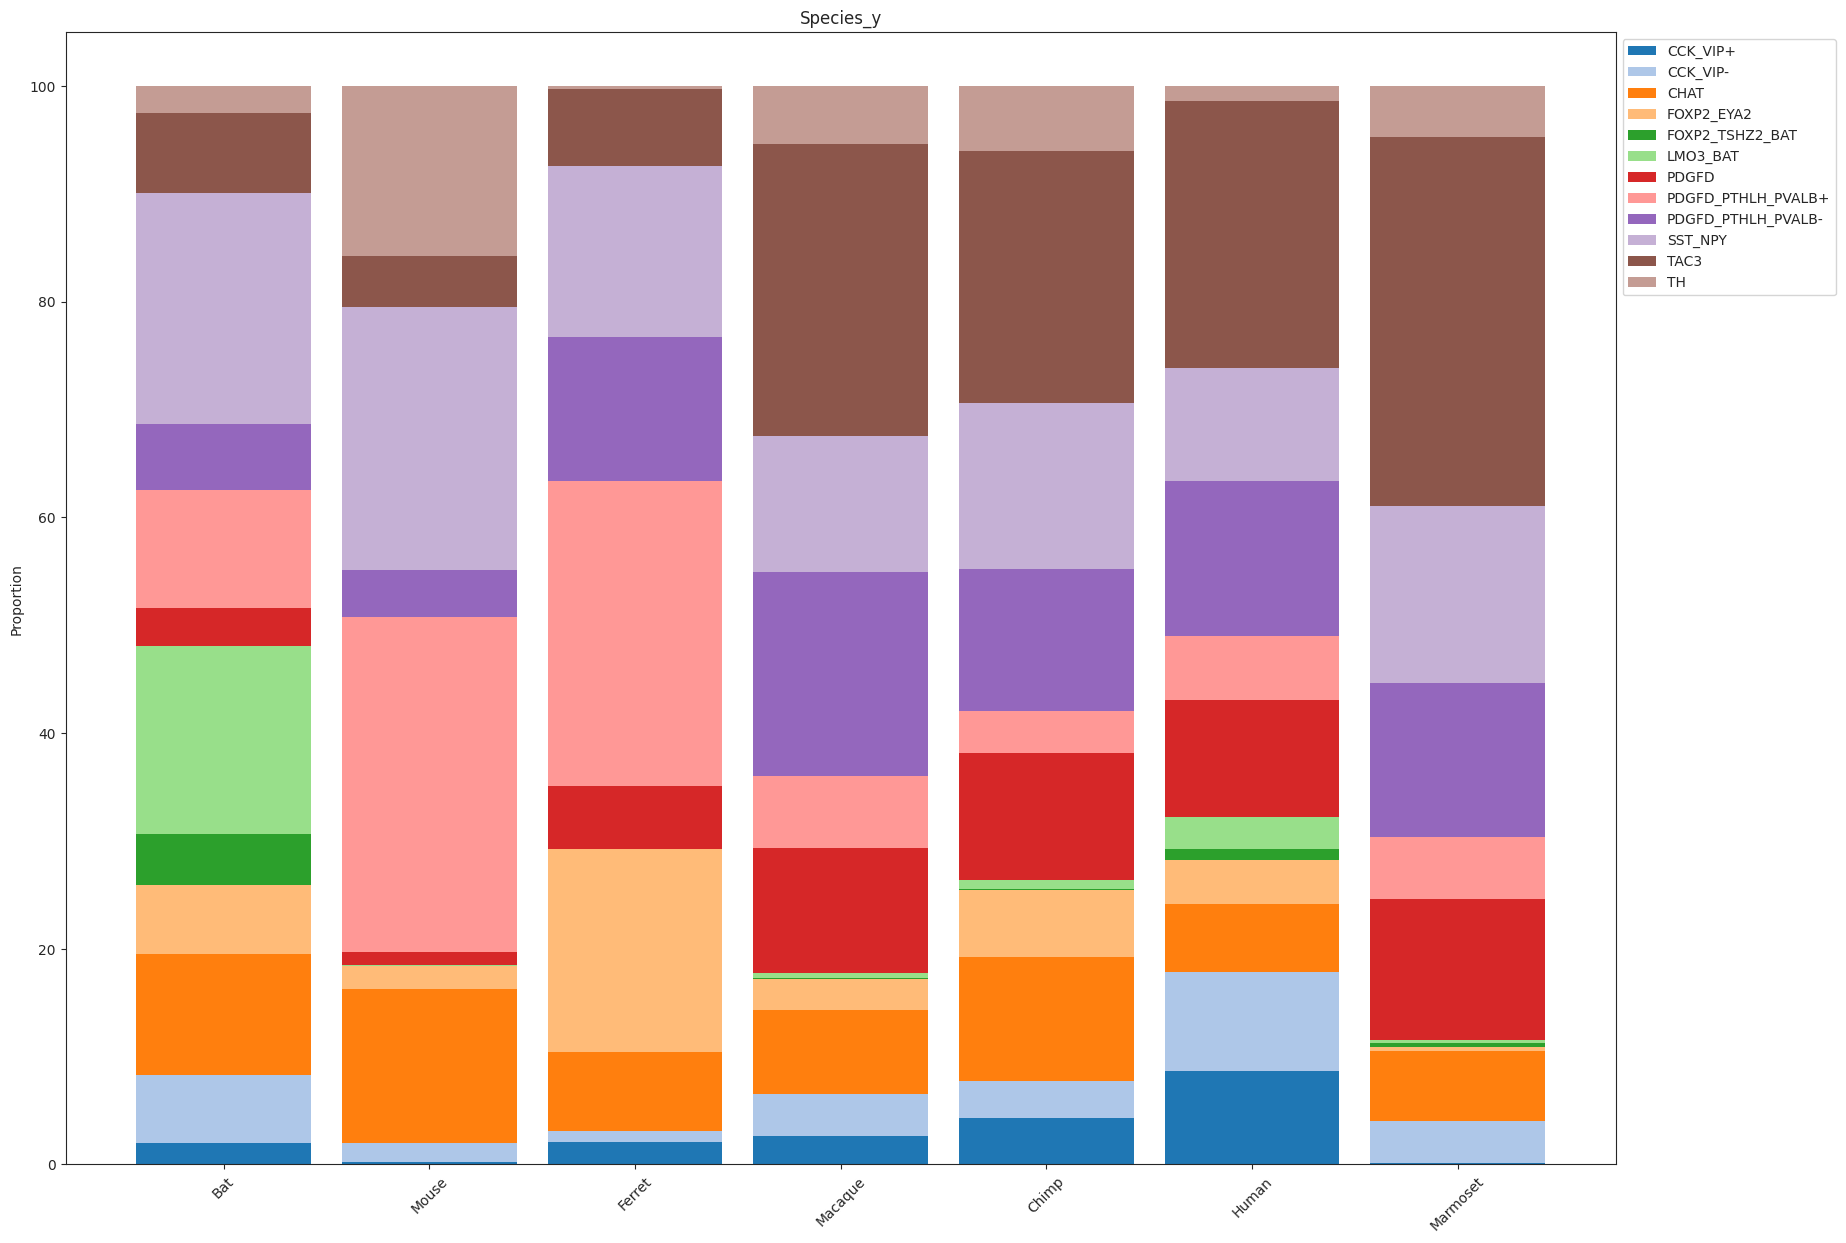

In [11]:
# Stacked barplot for the levels of "Species"
viz.stacked_barplot(data_non_SPN_put, feature_name="Species_y", figsize=(20, 15))
viz.stacked_barplot(data_non_SPN_caud, feature_name="Species_y", figsize=(20, 15))
viz.stacked_barplot(data_non_SPN_all, feature_name="Species_y", figsize=(20, 15))

### scCODA - Finding a reference cell type
Per suggestion from the scCODA manual we'll use the dispersion-abundance plots per Tissue to decide which cell type should be the reference. The ideal reference cell type is the one with the highest abundance and lowest dispersion.

In [12]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /endosome/work/Neuroinformatics_Core/gkonop/06_QC_plots


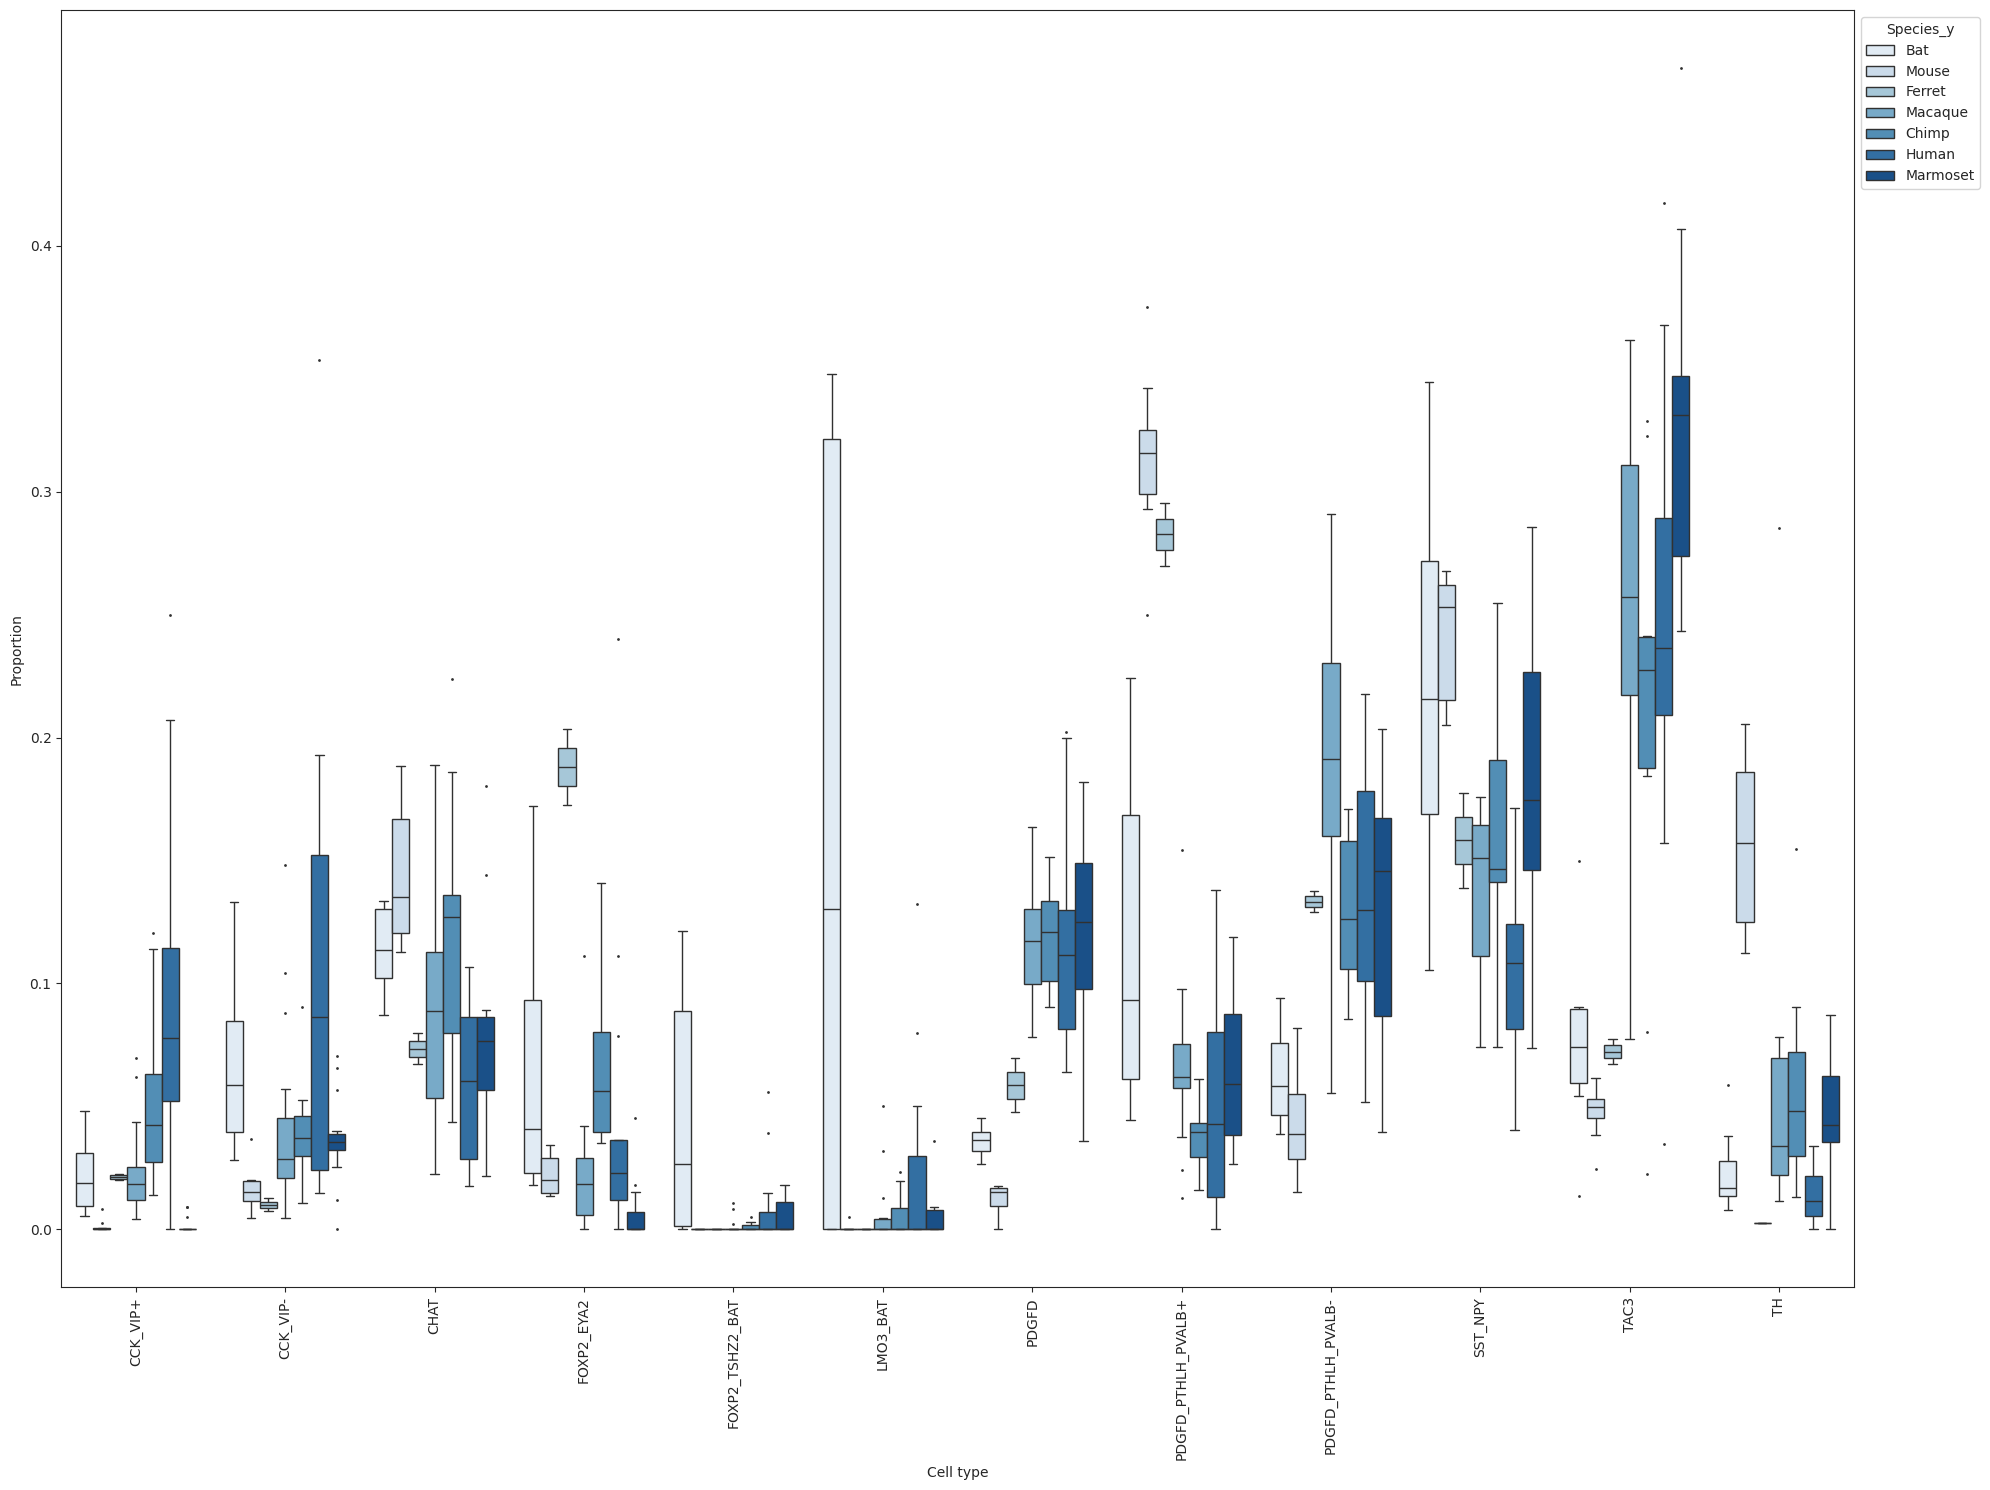

In [13]:
viz.boxplots(data_non_SPN_all, feature_name="Species_y", figsize=(20, 15))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


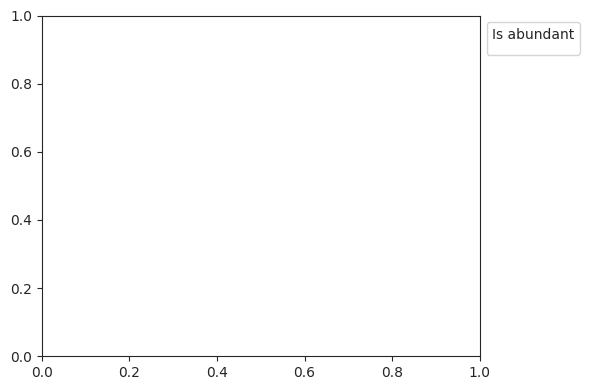

In [14]:
import matplotlib.pyplot as plt

## putamen and caudoputamen relative abundance polot
viz.rel_abundance_dispersion_plot(data=data_non_SPN_put, abundant_threshold=0.9)
plt.title("Putamen and Caudoputamen- Relative Abundance Dispersion Plot", fontsize=20)

# Adjust the label positions to avoid overlap
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels and align them
plt.yticks(fontsize=12)  # Adjust font size for y-axis labels

# Save the plot with your exact file name
plt.savefig("Interneuron_Putamen_and_Caudoputamen_rel_abundance_dispersion_plot.svg", bbox_inches='tight')

# Close the plot to free up memory
plt.close()


## caudate and caudoputamen relative abundance polot
import matplotlib.pyplot as plt

# Create a figure with adjusted width and height (e.g., width=12, height=8)
plt.figure(figsize=(12, 8))  # You can change this to your desired dimensions

# Create the relative abundance dispersion plot for the Caudate and Caudoputamen
viz.rel_abundance_dispersion_plot(data=data_non_SPN_caud, abundant_threshold=0.9)

# Title and axis adjustments
plt.title("Caudate and Caudoputamen - Relative Abundance Dispersion Plot", fontsize=20)

# Adjust x-axis and y-axis label positions
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels and align them
plt.yticks(fontsize=12)  # Adjust font size for y-axis labels

# Adjust the distance between axis and labels (make them closer)
plt.xlabel('Sample ID', fontsize=14, labelpad=10)  # Reduce labelpad to bring x-axis label closer
plt.ylabel('Relative Abundance', fontsize=14, labelpad=10)  # Reduce labelpad to bring y-axis label closer

# Use tight_layout to automatically adjust plot spacing
plt.tight_layout()

# Save the plot as an SVG
plt.savefig("Interneuron_Caudate_and_Caudoputamen_rel_abundance_dispersion_plot_tight.svg", bbox_inches='tight')

# Close the plot to free up memory
plt.close()


### scCODA - Model

In [15]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
# change human as the control category: C(NameOfTheColumnofSpecies, Treatment('Human'))
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use putamen only
model_putamen = mod.CompositionalAnalysis(data_non_SPN_put, formula="C(Species_y, Treatment('Human'))", reference_cell_type="SST_NPY")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.1)
putamen_results.summary_extended()

# Run the function and inspect the raw output
human_putamen_raw_results = putamen_results.credible_effects(data_non_SPN_put)
print(human_putamen_raw_results)

# save results
import pandas as pd

# Reset index to flatten the multi-level index and convert to a DataFrame
putamen_df = human_putamen_raw_results.reset_index()

# Optionally, you can rename the columns for clarity
putamen_df.columns = ['Covariate', 'Cell Type', 'Final Parameter']

# Save the DataFrame to CSV
putamen_df.to_csv('scCODA_Interneuron_putamen_HumanvsRest_results_fdr0_1.csv', index=False)

print("CSV file 'scCODA_Interneuron_putamen_HumanvsRest_results_fdr0_1.csv' created successfully.")

import io
import sys

# Capture the printed output of summary_extended()
output = io.StringIO()
sys.stdout = output  # Redirect stdout to capture printed output

putamen_results.summary_extended()  # Call summary_extended, which prints the result

sys.stdout = sys.__stdout__  # Restore stdout to original

# Save the captured output to a text file
with open('scCODA_Interneuron_putamen_HumanvsRest_mouse_included_summary_extended_fdr0_1.txt', 'w') as f:
    f.write(output.getvalue())

print("Text file 'scCODA_Interneuron_putamen_HumanvsRest_mouse_included_summary_extended_0_1.txt' created successfully.")


Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [05:18<00:00, 62.79it/s]


MCMC sampling finished. (399.236 sec)
Acceptance rate: 43.5%
Compositional Analysis summary (extended):

Data: 246 samples, 12 cell types
Reference index: 9
Formula: C(Species_y, Treatment('Human'))
Spike-and-slab threshold: 0.680

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 399.236 sec. Acceptance rate: 43.5%

Intercepts:
                    Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                                   
CCK_VIP+                      1.026   0.757    1.305  0.147         2.983689
CCK_VIP-                      1.137   0.922    1.377  0.123         3.333959
CHAT                          1.624   1.432    1.800  0.099         5.425774
FOXP2_EYA2                    0.994   0.739    1.250  0.137         2.889723
FOXP2_TSHZ2_BAT               0.509   0.297    0.717  0.111         1.779194
LMO3_BAT                      0.635   0.397    0.874  0.128         2.018108
PDGFD                         1.623 

In [17]:
# use caudate only
model_caudate = mod.CompositionalAnalysis(data_non_SPN_caud, formula="C(Species_y, Treatment('Human'))", reference_cell_type="PDGFD")
caudate_results = model_caudate.sample_hmc()
caudate_results.set_fdr(0.1)
caudate_results.summary_extended()

# Run the function and inspect the raw output
human_caudate_raw_results = caudate_results.credible_effects(data_non_SPN_caud)
print(human_caudate_raw_results)

# save results
import pandas as pd

# Reset index to flatten the multi-level index and convert to a DataFrame
caudate_df = human_caudate_raw_results.reset_index()

# Optionally, you can rename the columns for clarity
caudate_df.columns = ['Covariate', 'Cell Type', 'Final Parameter']

# Save the DataFrame to CSV
caudate_df.to_csv('scCODA_Interneuron_caudate_HumanvsRest_mouse_included_results_fdr0_1.csv', index=False)


print("CSV file 'scCODA_Interneuron_caudate_HumanvsRest_mouse_included_results_fdr0_1.csv' created successfully.")

import io
import sys

# Capture the printed output of summary_extended()
output = io.StringIO()
sys.stdout = output  # Redirect stdout to capture printed output

caudate_results.summary_extended()  # Call summary_extended, which prints the result

sys.stdout = sys.__stdout__  # Restore stdout to original

# Save the captured output to a text file
with open('scCODA_Interneuron_caudate_HumanvsRest_mouse_included_summary_extended_fdr0_1.txt', 'w') as f:
    f.write(output.getvalue())
print("Text file 'scCODA_Interneuron_caudate_HumanvsRest_mouse_included_summary_extended_0_1.txt' created successfully.")



100%|██████████| 20000/20000 [05:38<00:00, 59.14it/s]


In [18]:
# Run the function and inspect the raw output
human_caudate_raw_results = caudate_results.credible_effects(data_non_SPN_caud)
print(human_caudate_raw_results)

# save results
import pandas as pd

# Reset index to flatten the multi-level index and convert to a DataFrame
caudate_df = human_caudate_raw_results.reset_index()

# Optionally, you can rename the columns for clarity
caudate_df.columns = ['Covariate', 'Cell Type', 'Final Parameter']

# Save the DataFrame to CSV
caudate_df.to_csv('scCODA_Interneuron_caudate_HumanvsRest_mouse_included_results_fdr0_1.csv', index=False)


print("CSV file 'scCODA_Interneuron_caudate_HumanvsRest_mouse_included_results_fdr0_1.csv' created successfully.")

import io
import sys

# Capture the printed output of summary_extended()
output = io.StringIO()
sys.stdout = output  # Redirect stdout to capture printed output

caudate_results.summary_extended()  # Call summary_extended, which prints the result

sys.stdout = sys.__stdout__  # Restore stdout to original

# Save the captured output to a text file
with open('scCODA_Interneuron_caudate_HumanvsRest_mouse_included_summary_extended_fdr0_1.txt', 'w') as f:
    f.write(output.getvalue())

print("Text file 'scCODA_Interneuron_caudate_HumanvsRest_mouse_included_summary_extended_0_1.txt' created successfully.")


In [19]:
# change human as the control category: C(NameOfTheColumnofSpecies, Treatment('Human'))
# C(): This function is used to specify categorical variables in the formula. It tells the model to treat Species_y as a categorical variable.
# use putamen only
model_putamen = mod.CompositionalAnalysis(data_non_SPN_put, formula="C(Species_y, Treatment('Bat'))", reference_cell_type="SST_NPY")
putamen_results = model_putamen.sample_hmc()
putamen_results.set_fdr(0.1)
putamen_results.summary_extended()

# Run the function and inspect the raw output
putamen_raw_results = putamen_results.credible_effects(data_non_SPN_put)
print(putamen_raw_results)



100%|██████████| 20000/20000 [05:14<00:00, 63.67it/s]


In [20]:
import pandas as pd

# Reset index and save the credible effects results
putamen_raw_results = putamen_results.credible_effects(data_non_SPN_put)

# Reset index to flatten the multi-level index and convert to a DataFrame
putamen_df = putamen_raw_results.reset_index()

# Optionally, you can rename the columns for clarity
putamen_df.columns = ['Covariate', 'Cell Type', 'Final Parameter']

# Save the DataFrame to CSV
putamen_df.to_csv('scCODA_Interneuron_putamen_BatvsRest_mouse_included_results_fdr0_1.csv', index=False)

print("CSV file 'scCODA_Interneuron_putamen_BatvsRest_mouse_included_results_fdr0_1.csv' created successfully.")


In [21]:
import io
import sys

# Capture the printed output of summary_extended()
output = io.StringIO()
sys.stdout = output  # Redirect stdout to capture printed output

putamen_results.summary_extended()  # Call summary_extended, which prints the result

sys.stdout = sys.__stdout__  # Restore stdout to original

# Save the captured output to a text file
with open('scCODA_Interneuron_putamen_BatvsRest_mouse_included_summary_extended_fdr0_1.txt', 'w') as f:
    f.write(output.getvalue())

print("Text file 'scCODA_Interneuron_putamen_BatvsRest_mouse_included_summary_extended_0_1.txt' created successfully.")
